In [1]:
import sys
import torch
from torchvision import transforms, datasets
import numpy as np
import random
import os
from sklearn.decomposition import PCA


In [2]:
data_name = 'cifar10'
model_name = 'resnet'
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = datasets.CIFAR10
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), normalize])

eval_transform = transforms.Compose([transforms.ToTensor(), normalize])

In [3]:
train_data = dataset('datasets', train=True, transform=train_transform, download=True)
test_data = dataset('datasets', train=False, transform=eval_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


In [4]:
idx_train = []
for i, tar in enumerate(train_data.targets):
    if tar == 0 or tar == 1 or tar == 2 or tar == 3:
        idx_train.append(i)

idx_test = []
for i, tar in enumerate(test_data.targets):
    if tar == 0 or tar == 1 or tar == 2 or tar == 3:
        idx_test.append(i)

train_data_data = train_data.data[idx_train]
train_data_targets = np.array(train_data.targets)[idx_train]

test_data_data = test_data.data[idx_test]
test_data_targets = np.array(test_data.targets)[idx_test]

## Run PCA on Train DATA

In [5]:
n_components = 100
data_size = len(train_data)


In [6]:

import pickle

n_train = train_data_data.shape[0]

#fllaten train data for pca
red_train= train_data_data[:,:,:,0].reshape(-1,1024)
green_train = train_data_data[:,:,:,1].reshape(-1,1024)
blue_train =  train_data_data[:,:,:,2].reshape(-1,1024)

#fit pca
pca_red, pca_blue, pca_green = PCA(n_components=n_components), PCA(n_components=n_components), PCA(n_components=n_components)
red_train_down= pca_red.fit_transform(red_train)
green_train_down= pca_green.fit_transform(green_train)
blue_train_down =pca_blue.fit_transform(blue_train)

#save pca results
np.save('red_train_down', red_train_down)
np.save('green_train_down', green_train_down)
np.save('blue_train_down', blue_train_down)
pickle.dump(pca_red, open('pca_red', 'wb'))
pickle.dump(pca_green, open('pca_green', 'wb'))
pickle.dump(pca_blue, open('pca_blue', 'wb'))



In [7]:
train_reshaped_down = np.zeros((n_train, n_components, 3))

red_train_down= np.load('red_train_down.npy')
green_train_down= np.load('green_train_down.npy')
blue_train_down = np.load('blue_train_down.npy')

train_reshaped_down[:,:,0] = red_train_down
train_reshaped_down[:,:,1]= green_train_down
train_reshaped_down[:,:,2] =  blue_train_down 
np.save('train_down', train_reshaped_down)


## Show images k=100 first components of images

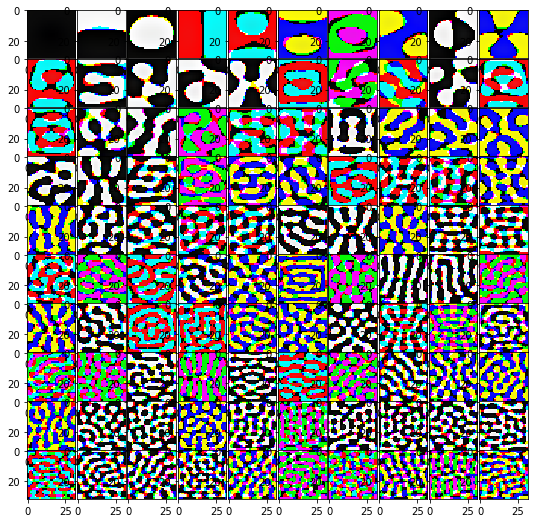

In [8]:
import matplotlib.pyplot as plt
import pickle

train_down= np.load('train_down.npy')
pca_red, pca_green, pca_blue = pickle.load(open('pca_red', 'rb')),  pickle.load(open('pca_green', 'rb')), pickle.load(open('pca_blue', 'rb'))


fig, axes = plt.subplots(10,10,figsize=(9,9),
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    pca = np.dstack(((pca_red.components_[i].reshape(32,32)*255.999).astype('uint8'),(pca_green.components_[i].reshape(32,32)*255.999).astype('uint8')\
            , (pca_blue.components_[i].reshape(32,32)*255.999).astype('uint8')))
    ax.imshow(pca, interpolation='nearest')



## Show reconstruction of images - projected on k=100 first components


In [9]:
# new_image = Image.fromarray(train_reshaped_down[0].astype('uint8'))
r_projected = pca_red.inverse_transform(red_train_down)
g_projected = pca_green.inverse_transform(green_train_down)
b_projected = pca_blue.inverse_transform(blue_train_down)
np.save('red_train_proj', r_projected)
np.save('green_train_proj', g_projected)
np.save('blue_train_proj', b_projected)

In [10]:
r_projected= np.load('red_train_proj.npy')
g_projected= np.load('green_train_proj.npy')
b_projected = np.load('blue_train_proj.npy')

train_projected = np.zeros((b_projected.shape[0], 32, 32, 3))
train_projected[:,:,:,0] = r_projected.reshape(r_projected.shape[0],32,32)
train_projected[:,:,:,1] = g_projected.reshape(g_projected.shape[0],32,32)
train_projected[:,:,:,2] = b_projected.reshape(b_projected.shape[0],32,32)

np.save('train_projected', train_projected)

Reconstruction images according to k=100 first principles components


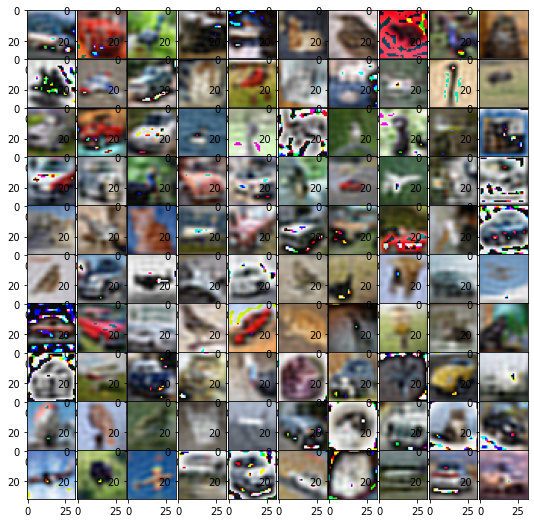

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


print("Reconstruction images according to k=100 first principles components")

fig, axes = plt.subplots(10,10,figsize=(9,9),
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_projected[i].astype('uint8'))



## Test manipulations

In [12]:
import pickle
n_test = test_data_data.shape[0]
#flatten test data for pca
red_test = test_data_data[:,:,:,0].reshape(-1,1024)
green_test = test_data_data[:,:,:,1].reshape(-1,1024)
blue_test =  test_data_data[:,:,:,2].reshape(-1,1024)

#run pca on train components
pca_red, pca_green, pca_blue = pickle.load(open('pca_red', 'rb')),  pickle.load(open('pca_green', 'rb')), pickle.load(open('pca_blue', 'rb'))
red_test_down = pca_red.transform(red_test)
green_test_down = pca_green.transform(green_test)
blue_test_down = pca_blue.transform(blue_test)

r_test_projected = pca_red.inverse_transform(red_test_down)
g_test_projected = pca_green.inverse_transform(green_test_down)
b_test_projected = pca_blue.inverse_transform(blue_test_down)


np.save('r_test_projected', r_test_projected)
np.save('g_test_projected', g_test_projected)
np.save('b_test_projected', b_test_projected)

## Save RGB test data into one data matrix

In [13]:

r_test_projected= np.load('r_test_projected.npy')
g_test_projected= np.load('g_test_projected.npy')
b_test_projected = np.load('b_test_projected.npy')


test_projected = np.zeros((b_test_projected.shape[0], 32, 32, 3))
test_projected[:,:,:,0] = r_test_projected.reshape(b_test_projected.shape[0],32,32)
test_projected[:,:,:,1] = g_test_projected.reshape(b_test_projected.shape[0],32,32)
test_projected[:,:,:,2] = b_test_projected.reshape(b_test_projected.shape[0],32,32)
np.save('test_projected', test_projected)

## Load DATA transformed

In [14]:
from torch.utils.data import TensorDataset

label_noise = 0.2
data_size = len(train_data_targets)
random_index = random.sample(range(data_size), int(data_size*label_noise))
random_part = train_data_targets[random_index]
np.random.shuffle(random_part)
train_data_targets[random_index] = random_part
train_data_targets = torch.IntTensor(train_data_targets)

train_projected= np.load('train_projected.npy')
train_projected = torch.tensor(train_projected)
train_dataset = TensorDataset(train_projected, train_data_targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0,
                                           drop_last=False)

test_down= np.load('test_projected.npy')
test_down = torch.tensor(test_down)
test_data_targets = torch.IntTensor(test_data_targets)
test_dataset_down = TensorDataset(test_down, test_data_targets)
test_loader = torch.utils.data.DataLoader(test_dataset_down, batch_size=100, shuffle=False, num_workers=0,
                                          drop_last=False)

## Build NN

In [15]:
from utils import progress_bar
from torchvision import models

In [16]:
# width
k = 4
num_classes = 4
label_noise = 0.2
n_epochs = 200
best_acc = 0  
acc_train = []
acc_test = []
loss_train = []
loss_test = []

model = models.resnet18(pretrained=True)
# build model
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()


num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model.fc = model.fc.cuda() if torch.cuda.is_available() else model.fc# Training
model = model.double()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,  momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def train(epoch, train_loader):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.permute(0, 3, 1, 2)
        ins, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(ins)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    loss_train.append(train_loss/(batch_idx+1))
    acc_train.append(100.*correct/total)


def test(epoch, test_loader):
    global best_acc
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.permute(0, 3, 1, 2)
            ins, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(ins)
            loss = criterion(outputs, targets.long())

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(test_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    loss_test.append(test_loss/(batch_idx+1))
    acc_test.append(100.*correct/total)

    # Save checkpoint.
    acc = 100.*correct/total
    print('Saving..')
    state = {
        'model': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')
    best_acc = acc


for epoch in range(0, n_epochs):
    train(epoch, train_loader)
    np.save('loss_train', np.array(loss_train))
    np.save('acc_train', np.array(acc_train))

    test(epoch, test_loader)
    np.save('acc_test', np.array(acc_test))
    np.save('loss_test', np.array(loss_test))
    
    scheduler.step()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


Epoch: 0


KeyboardInterrupt: ignored